In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [123]:
datapath = "../data/ICPSR_04351/DS0002/04351-0002-Data.csv"

dump = pd.read_csv(datapath)


unemployment_datapath = "../data/ECONOMIC/UNRATE.csv"
unemployment = pd.read_csv(unemployment_datapath)

In [124]:
dump = dump[["MONTH","YEAR", "VICSEX", "VICRACE", "OFFSEX", "OFFRACE", "RELATION", "CIRCUM", "POPGROUP", "STCODE"]]

# use date for joining
dump['DATE'] = pd.to_datetime(dump[['YEAR', 'MONTH']].assign(DAY=1)).dt.date 

dump["DATE_and_STATE"] = dump["DATE"].astype(str) + "_" + dump["STCODE"].astype(str)

dump["COUNT"] = 1

dump["IN_FAMILY"] = dump["RELATION"].apply(lambda x: 1 if 1 <= 1 and x <= 16 else 0)
dump["KILLED_CHILD"] = dump["RELATION"].apply(lambda x: 1 if x in [7,8] else 0)
dump["IN_CITY"] = dump["POPGROUP"].apply(lambda x: 1 if x in [1, 2, 10, 11, 12, 13, 20] else 0)
dump["IN_SUBURB"] = dump["POPGROUP"].apply(lambda x: 1 if x in [3, 4, 5, 30, 40, 50] else 0)
dump["IN_RURAL"] = dump["POPGROUP"].apply(lambda x: 1 if x not in [1, 2, 10, 11, 12, 13, 20, 3, 4, 5, 30, 40, 50] else 0)

# drop unknown race and unknown sex for offender
dump = dump[dump['OFFSEX'] != 9]
dump = dump[dump['OFFRACE'] != 9]

# Collapse Race into white, non white; collapse sex into male
dump['WHITE_OFF'] = dump['OFFRACE'].apply(lambda x : 1 if x == 1 else 0)
dump['MALE_OFF'] = dump['OFFSEX'].apply(lambda x: 1 if x == 1 else 0)


# D_S_PANEL = dump.groupby("DATE_and_STATE")[["COUNT","IN_FAMILY", "KILLED_CHILD", "IN_CITY", "IN_SUBURB", "IN_RURAL"]].sum()


In [126]:
# new granuality of data

# Cole's group by


# what we want to keep
groupby_cols = ["DATE", "IN_FAMILY", "KILLED_CHILD", "IN_CITY", "WHITE_OFF", "MALE_OFF", "IN_RURAL"]
# groupby_cols = ["DATE", "IN_FAMILY", ]


drop_cols = [col for col in dump.columns if col not in groupby_cols] 
print("dropped cols" , drop_cols)

ts = dump.drop(columns=drop_cols, axis=1)


# maybe try not counting
ts = ts.groupby(groupby_cols)['DATE'].agg('count').to_frame("Counts").reset_index()
ts['DATE'] = pd.to_datetime(ts['DATE'])

start_date =  pd.to_datetime("1976-01-01")

# periods
ts['start_date'] = start_date
ts['PERIOD'] = (ts['DATE'].dt.year - ts['start_date'].dt.year) * 12 + (ts['DATE'].dt.month - ts['start_date'].dt.month)
ts['PERIOD_SQ'] = ts['PERIOD'] **2
ts['LOG_PERIOD'] = np.log(ts['PERIOD'] + 1)



print(ts)


### simple ts2

# what we want to keep
groupby_cols2 = ["DATE", "IN_FAMILY"]
# groupby_cols = ["DATE", "IN_FAMILY", ]


drop_cols2 = [col for col in dump.columns if col not in groupby_cols2] 
print("dropped cols" , drop_cols)

ts2 = dump.drop(columns=drop_cols2, axis=1)


# maybe try not counting
ts2 = ts2.groupby(groupby_cols2)['DATE'].agg('count').to_frame("Counts").reset_index()
ts2['DATE'] = pd.to_datetime(ts2['DATE'])

start_date =  pd.to_datetime("1976-01-01")

# periods
ts2['start_date'] = start_date
ts2['PERIOD'] = (ts2['DATE'].dt.year - ts2['start_date'].dt.year) * 12 + (ts2['DATE'].dt.month - ts2['start_date'].dt.month)
ts2['PERIOD_SQ'] = ts2['PERIOD'] **2
ts2['LOG_PERIOD'] = np.log(ts2['PERIOD'] + 1)





dropped cols ['MONTH', 'YEAR', 'VICSEX', 'VICRACE', 'OFFSEX', 'OFFRACE', 'RELATION', 'CIRCUM', 'POPGROUP', 'STCODE', 'DATE_and_STATE', 'COUNT', 'IN_SUBURB']
            DATE  IN_FAMILY  KILLED_CHILD  IN_CITY  WHITE_OFF  MALE_OFF  \
0     1976-01-01          0             0        0          0         0   
1     1976-01-01          0             0        0          0         0   
2     1976-01-01          0             0        0          0         1   
3     1976-01-01          0             0        0          0         1   
4     1976-01-01          0             0        0          1         0   
...          ...        ...           ...      ...        ...       ...   
11584 2003-12-01          1             1        0          1         1   
11585 2003-12-01          1             1        1          0         0   
11586 2003-12-01          1             1        1          0         1   
11587 2003-12-01          1             1        1          1         0   
11588 2003-12-01  

In [127]:

# make both dates same type before merge

unemployment['DATE'] = pd.to_datetime(unemployment['DATE'])

# add year only column for inflation merge
ts['YEAR'] = ts['DATE'].dt.year

ts2['YEAR'] = ts2['DATE'].dt.year


In [128]:
# inflation data
inflation_df = pd.read_csv('../data/ECONOMIC/FPCPITOTLZGUSA.csv')
inflation_df['DATE'] = pd.to_datetime(inflation_df['DATE'])
inflation_df['YEAR'] = inflation_df['DATE'].dt.year
inflation_df.rename(columns={"FPCPITOTLZGUSA": "CPI"}, inplace=True)

In [129]:
population_df = pd.read_csv('../data/ECONOMIC/POPTHM.csv')
population_df['DATE'] = pd.to_datetime(population_df['DATE'])
population_df.rename(columns={"POPTHM": "POP"}, inplace=True)

In [130]:
# Merge on date
ts = ts.merge(unemployment, how="left", on='DATE')
ts = ts.merge(population_df, how='left', on='DATE')
ts = ts.merge(inflation_df[['YEAR', 'CPI']], how='left', on='YEAR')

ts2 = ts2.merge(unemployment, how="left", on='DATE')
ts2 = ts2.merge(population_df, how='left', on='DATE')
ts2 = ts2.merge(inflation_df[['YEAR', 'CPI']], how='left', on='YEAR')

In [131]:
# use pop to get in family murder RATE  
ts['MURDERS_PER_100K'] = ts['Counts'] / (ts['POP'] / 100)

ts2['MURDERS_PER_100K'] = ts2['Counts'] / (ts2['POP'] / 100)

## More complicated Reg 

In [153]:
# DON'T MODIFY ts HERE

# drop any rows that are not infamily murders
reg_data = ts[ts['IN_FAMILY'] == 1]

x = reg_data[["UNRATE", 'CPI', "WHITE_OFF", "MALE_OFF", "IN_RURAL", 'PERIOD', 'PERIOD_SQ']]
x = sm.add_constant(x)
y = ((reg_data["MURDERS_PER_100K"]))


model = sm.OLS(y, x).fit()

print(model.summary())

from statsmodels.iolib.summary2 import summary_col
res = summary_col(model, stars=True,  info_dict={
        'Observations':lambda x: "{0:d}".format(int(x.nobs)),
    })
print(res)

# dependent variable mean (putting in the summary stats table)



                            OLS Regression Results                            
Dep. Variable:       MURDERS_PER_100K   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     301.6
Date:                Sun, 28 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:02:32   Log-Likelihood:                 30726.
No. Observations:                7563   AIC:                        -6.144e+04
Df Residuals:                    7555   BIC:                        -6.138e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.421      0.0

### More complicated Reg with Iteration terms

In [154]:
reg_data = ts[ts['IN_FAMILY'] == 1]
reg_data['UNRATExWHITE'] = reg_data['UNRATE'] * reg_data['WHITE_OFF']
reg_data['UNRATExMALE'] = reg_data['UNRATE'] * reg_data['MALE_OFF']
reg_data['UNRATExRURAL'] = reg_data['UNRATE'] * reg_data['IN_RURAL']
reg_data['CPIxWHITE'] = reg_data['CPI'] * reg_data['WHITE_OFF']
reg_data['CPIxMALE'] = reg_data['CPI'] * reg_data['MALE_OFF']
reg_data['CPIxRURAL'] = reg_data['CPI'] * reg_data['IN_RURAL']



x = reg_data[["UNRATE", 'CPI', "WHITE_OFF", "MALE_OFF", "IN_RURAL", 'PERIOD', 'PERIOD_SQ', 'UNRATExWHITE', 'UNRATExMALE','UNRATExRURAL', 'CPIxWHITE', 'CPIxMALE', 'CPIxRURAL']]
x = sm.add_constant(x)
y = ((reg_data["MURDERS_PER_100K"]))


model_interaction = sm.OLS(y, x).fit()

print(model_interaction.summary())

from statsmodels.iolib.summary2 import summary_col
res = summary_col([model, model_interaction], stars=True,  info_dict={
        'Observations':lambda x: "{0:d}".format(int(x.nobs)),
    })
print(res)

                            OLS Regression Results                            
Dep. Variable:       MURDERS_PER_100K   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     165.0
Date:                Sun, 28 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:02:34   Log-Likelihood:                 30740.
No. Observations:                7563   AIC:                        -6.145e+04
Df Residuals:                    7549   BIC:                        -6.135e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0033      0.001      5.569   

/var/folders/47/0p6nq2294x1d5h7qj8zfwf440000gn/T/ipykernel_32314/1031952110.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_data['UNRATExWHITE'] = reg_data['UNRATE'] * reg_data['WHITE_OFF']
/var/folders/47/0p6nq2294x1d5h7qj8zfwf440000gn/T/ipykernel_32314/1031952110.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_data['UNRATExMALE'] = reg_data['UNRATE'] * reg_data['MALE_OFF']
/var/folders/47/0p6nq2294x1d5h7qj8zfwf440000gn/T/ipykernel_32314/1031952110.py:4: SettingWithCopyWarning: 
A value is 

### Simple Reg

In [140]:
# drop any rows that are not infamily murders

reg_data_simple = ts2[ts2['IN_FAMILY'] == 1]


x = reg_data_simple[["UNRATE", 'CPI', 'PERIOD', 'PERIOD_SQ']]
x = sm.add_constant(x)
y = ((reg_data_simple["MURDERS_PER_100K"]))


model = sm.OLS(y, x).fit()

# average number of annual in-family murders
print(reg_data_simple['Counts'].mean() * 12)

print(model.summary())

from statsmodels.iolib.summary2 import summary_col
res = summary_col(model, stars=True,  info_dict={
        'Observations':lambda x: "{0:d}".format(int(x.nobs)),
    })
print(res)

2690.9285714285716
                            OLS Regression Results                            
Dep. Variable:       MURDERS_PER_100K   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     900.4
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.97e-176
Time:                        14:48:22   Log-Likelihood:                 1136.7
No. Observations:                 336   AIC:                            -2263.
Df Residuals:                     331   BIC:                            -2244.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1072      0.005 

### Extra plots and figs for paper

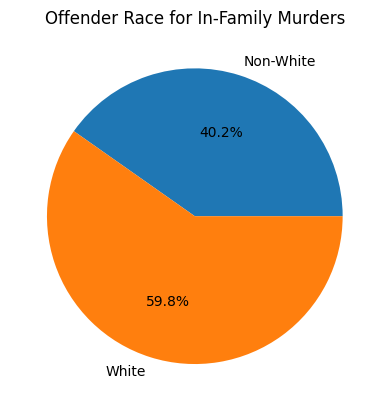

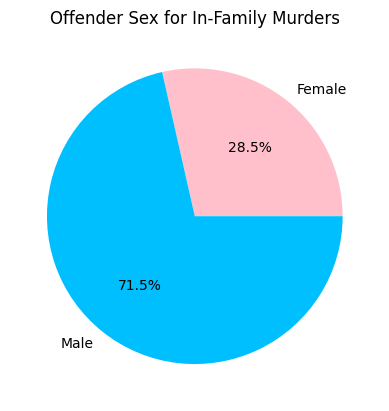

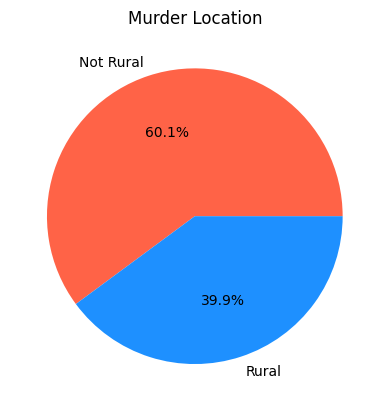

In [141]:
by_race = reg_data.groupby(['WHITE_OFF']).sum('Counts')
by_sex = reg_data.groupby(['MALE_OFF']).sum('Counts')
by_rural = reg_data.groupby(['IN_RURAL']).sum('Counts')

plt.pie(by_race['Counts'], labels=['Non-White', 'White'], normalize=True, autopct='%1.1f%%')
plt.title("Offender Race for In-Family Murders")
plt.show()


plt.pie(by_sex['Counts'], labels=['Female', 'Male'], normalize=True, autopct='%1.1f%%', colors=['Pink', 'deepskyblue'])
plt.title("Offender Sex for In-Family Murders")
plt.show()

plt.pie(by_rural['Counts'], labels=['Not Rural', 'Rural'], normalize=True, autopct='%1.1f%%', colors=['tomato', 'dodgerblue'])
plt.title("Murder Location")
plt.show()

In [142]:
## more plots

by_sex_race = reg_data.groupby(['WHITE_OFF', 'MALE_OFF']).sum('Counts')

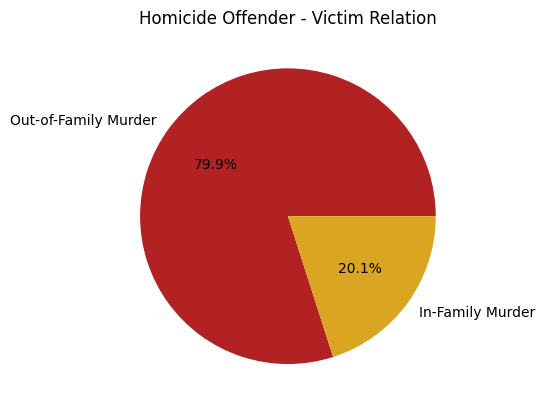

In [143]:
# number of in family murders vs non in family
by_in_family = ts.groupby(['IN_FAMILY']).sum('Counts')

plt.pie(by_in_family['Counts'], labels=['Out-of-Family Murder', 'In-Family Murder'], normalize=True, autopct='%1.1f%%', colors=['firebrick', 'goldenrod'])
plt.title("Homicide Offender - Victim Relation")
plt.show()



In [144]:
# getting total number of in family murders 

reg_data.groupby('YEAR').sum('Counts').mean()

IN_FAMILY           2.701071e+02
KILLED_CHILD        1.281071e+02
IN_CITY             9.467857e+01
WHITE_OFF           1.407857e+02
MALE_OFF            1.372857e+02
IN_RURAL            8.914286e+01
Counts              2.690929e+03
PERIOD              4.502954e+04
PERIOD_SQ           1.001846e+07
LOG_PERIOD          1.303760e+03
UNRATE              1.715575e+03
POP                 6.801794e+07
CPI                 1.224907e+03
MURDERS_PER_100K    1.095879e+00
dtype: float64